In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import OneClassSVM
from numpy import where
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
diabdata = pd.read_csv('diabetes_dataset__2019.csv')

In [3]:
diabdata.head(20)

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,no
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,no
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,no
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,no
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no
5,40-49,Male,no,yes,none,21.0,no,yes,10,10,no,occasionally,sometimes,high,0.0,0,not much,yes
6,less than 40,Male,no,no,one hr or more,24.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,no
7,less than 40,Male,no,no,less than half an hr,20.0,no,no,7,7,yes,occasionally,sometimes,low,0.0,0,not much,no
8,40-49,Male,yes,no,one hr or more,23.0,no,no,7,7,no,occasionally,sometimes,normal,0.0,0,not much,no
9,less than 40,Male,no,no,more than half an hr,20.0,no,no,8,8,o,occasionally,sometimes,normal,0.0,0,not much,no


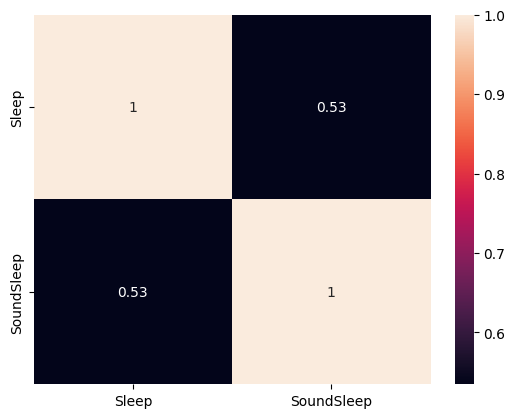

In [4]:
corr_sleep_df = diabdata[['Sleep', 'SoundSleep']] #select sleep and soundsleep
corr_sleep_mat = corr_sleep_df.corr() #correlation matrix btw two variables
sns.heatmap(corr_sleep_mat, annot=True)
plt.show()

In [5]:
#compute a simple cross tabulation of two (or more) factors
cross_tab_junk_stress = pd.crosstab(diabdata['JunkFood'], diabdata['Stress']) 
#want only first two values of tuple returned from chi2_contingency
#This function computes the chi-square statistic and p-value for the 
#hypothesis test of independence of the observed frequencies in the contingency table
chi2, p_value, df, expvals = chi2_contingency(cross_tab_junk_stress)
print("Chi-square:", chi2)
print("P-value:", p_value)
#We can assume from the low p value that junk food and stress are associated
#However, we will use both since their nature is different

Chi-square: 94.09466967499688
P-value: 2.4470337530291514e-16


In [6]:
cross_tab_junk_blood = pd.crosstab(diabdata['JunkFood'], diabdata['BPLevel']) 
chi2, p_value, df, expvals = chi2_contingency(cross_tab_junk_blood)
print("Chi-square:", chi2)
print("P-value:", p_value)
#Here, we see that junk food as blood pressure are not that highly correlated because the p-val > 0.05
#The chi-square value is also relatively low, demonstraing the above

Chi-square: 24.951722830335264
P-value: 0.05059555690352423


In [7]:
cross_tab_high_blood = pd.crosstab(diabdata['highBP'], diabdata['BPLevel']) 
chi2, p_value, df, expvals = chi2_contingency(cross_tab_high_blood)
print("Chi-square:", chi2)
print("P-value:", p_value)
#As expetced, the variables highBP and BPlevels are highly correlated because they relate both to blood pressure
#Because of the extremely high chi-square and low p-val we are likely to omit one of the two

Chi-square: 482.23875003776743
P-value: 5.439974203257661e-102


In [8]:
diabdata.dropna(subset = ['BMI', 'Sleep', 'SoundSleep'], inplace=True) #drops nan values from quantitative variables for now
diab_quant = diabdata[['BMI', 'Sleep', 'SoundSleep']] #the quantiative variables we want
target = diabdata['Diabetic'] #the label we want to predict
lab_encoder = LabelEncoder() #encode target labels with value between 0 and n_classes-1
target = lab_encoder.fit_transform(target) #transform target lab encoded
#split into 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(diab_quant, target, test_size = 0.2, random_state = 12)
#knn instant with 5 neighbors
knn_classifier = KNeighborsClassifier(n_neighbors = 5)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test) #show original yes/no's instead of 1/2's
predicted = lab_encoder.inverse_transform(y_pred)
true = lab_encoder.inverse_transform(y_test)
for pred, true in zip(predicted, true):
    print(f"Predicted: {pred}\tTrue: {true}")

Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: yes
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: n

In [9]:
true_labs = lab_encoder.inverse_transform(y_test) #there was an issue if I didn't inverse transform
predicted = predicted
conf_mat = confusion_matrix(true_labs, predicted)
conf_mat

array([[121,  18],
       [ 23,  28]], dtype=int64)

In [10]:
acc_sco = accuracy_score(true_labs, predicted)
acc_sco

0.7842105263157895

In [11]:
XMLP = diabdata.drop('Diabetic', axis=1)
yMLP = diabdata['Diabetic']
cat_MLP = ['Gender', 'Family_Diabetes', 'PhysicallyActive', 'Smoking', 'Alcohol', 'JunkFood', 'BPLevel']
num_MLP = ['BMI','Sleep','SoundSleep']
#encode categorical variables and scale quantitative
preprocessor_MLP = ColumnTransformer(transformers = [
    ('cat', OneHotEncoder(), cat_MLP),
    ('num', StandardScaler(), num_MLP)
])
XMLP_preproc = preprocessor_MLP.fit_transform(XMLP) #apply preprocessing

#train-test 80-20
X_trainMLP, X_testMLP, y_trainMLP, y_testMLP = train_test_split(XMLP_preproc, yMLP, test_size=0.2, random_state=12)
#using standard MLPClassifier activation and solver, as well as hidden layer sizes of 100 neurons for 2 layers
mlp = MLPClassifier(hidden_layer_sizes = (100,100), activation = 'relu', 
                    solver = 'adam', random_state = 12, max_iter=300)

mlp.fit(X_trainMLP, y_trainMLP)
y_predMLP = mlp.predict(X_testMLP)
accMLP = np.mean(y_predMLP == y_testMLP)
accMLP

0.9631578947368421

In [12]:
from sklearn.model_selection import GridSearchCV

activations = ['relu', 'logistic', 'tanh']
solvers = ['sgd', 'adam']
max_iterations = [1000,1100,1200,1300,1400,1500]
hidden_layer_siz = [(5, 7), (7, 13), (13, 10), (12,13), (5, 7, 7), (10, 12, 13), (20, 20), (12, 20), (18, 18), (21,21), (24,24)]
learning_rates = 0.01 * np.arange(1, 3)
batch_siz = [25, 50, 75, 100]

param_grid = dict(learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations, activation = activations, solver = solvers, batch_size = batch_siz)
# set model
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.3, batch_size = 100, hidden_layer_sizes = (12, 3), max_iter = 500)

# For Grid Search
grid = GridSearchCV(estimator = mlp, param_grid = param_grid)

grid.fit(X_trainMLP,y_trainMLP)

print("Optimal Hyper-parameters : ", grid.best_params_)
print("Optimal Accuracy : ", grid.best_score_)

c:\Users\jpsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\jpsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jpsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jpsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1100) reached and the optimization hasn't converged yet.
  wa

Optimal Hyper-parameters :  {'activation': 'tanh', 'batch_size': 25, 'hidden_layer_sizes': (18, 18), 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'sgd'}
Optimal Accuracy :  0.9419571279191356


In [18]:
XMLP = diabdata.drop('Diabetic', axis=1)
yMLP = diabdata['Diabetic']
cat_MLP = ['Gender', 'Family_Diabetes', 'PhysicallyActive', 'Smoking', 'Alcohol', 'JunkFood', 'BPLevel']
num_MLP = ['BMI','Sleep','SoundSleep']
#encode categorical variables and scale quantitative
preprocessor_MLP = ColumnTransformer(transformers = [
    ('cat', OneHotEncoder(), cat_MLP),
    ('num', StandardScaler(), num_MLP)
])
XMLP_preproc = preprocessor_MLP.fit_transform(XMLP) #apply preprocessing

#train-test 80-20
X_trainMLP, X_testMLP, y_trainMLP, y_testMLP = train_test_split(XMLP_preproc, yMLP, test_size=0.2, random_state=12)
#using standard MLPClassifier activation and solver, as well as hidden layer sizes of 100 neurons for 2 layers
mlp = MLPClassifier(hidden_layer_sizes = (18,18), activation = 'tanh', 
                    solver = 'sgd', random_state = 42, max_iter=1000, batch_size=25)

mlp.fit(X_trainMLP, y_trainMLP)
y_predMLP = mlp.predict(X_testMLP)
accMLP = np.mean(y_predMLP == y_testMLP)
accMLP

0.9421052631578948

In [49]:
# change diabetic to 0 and 1
diabdata_encoded = pd.get_dummies(diabdata, columns = ['Diabetic'])
diabdata_encoded = diabdata_encoded.drop(['Diabetic_ no'], axis = 1)
diabdata_encoded = diabdata_encoded.drop(['Diabetic_no'], axis = 1)
diabdata_encoded

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,Sleep,SoundSleep,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic_yes
0,50-59,Male,no,yes,one hr or more,39.0,no,no,8,6,no,occasionally,sometimes,high,0.0,0,not much,0
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,8,6,yes,very often,sometimes,normal,0.0,0,not much,0
2,40-49,Male,no,no,one hr or more,24.0,no,no,6,6,no,occasionally,sometimes,normal,0.0,0,not much,0
3,50-59,Male,no,no,one hr or more,23.0,no,no,8,6,no,occasionally,sometimes,normal,0.0,0,not much,0
4,40-49,Male,no,no,less than half an hr,27.0,no,no,8,8,no,occasionally,sometimes,normal,0.0,0,not much,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,less than 40,Male,yes,no,more than half an hr,25.0,no,no,8,6,no,often,sometimes,normal,0.0,0,not much,1
948,60 or older,Male,yes,yes,more than half an hr,27.0,no,no,6,5,yes,occasionally,sometimes,high,0.0,0,quite often,1
949,60 or older,Male,no,yes,none,23.0,no,no,6,5,yes,occasionally,sometimes,high,0.0,0,not much,0
950,60 or older,Male,no,yes,less than half an hr,27.0,no,yes,6,5,yes,occasionally,very often,high,0.0,0,not much,0


In [50]:
# total rows(observations) and columns(attributess)
diabdata_encoded.shape

(952, 18)

In [51]:
# summary statistics for quantiative variables
diabdata_encoded.describe()

,BMI,Sleep,SoundSleep,Pregancies,Diabetic_yes
count,948.000000,952.000000,952.000000,910.000000,952.000000
mean,25.763713,6.949580,5.495798,0.386813,0.279412
std,5.402595,1.273189,1.865618,0.909455,0.448946
min,15.000000,4.000000,0.000000,0.000000,0.000000
25%,22.000000,6.000000,4.000000,0.000000,0.000000
50%,25.000000,7.000000,6.000000,0.000000,0.000000
75%,29.000000,8.000000,7.000000,0.000000,1.000000
max,45.000000,11.000000,11.000000,4.000000,1.000000


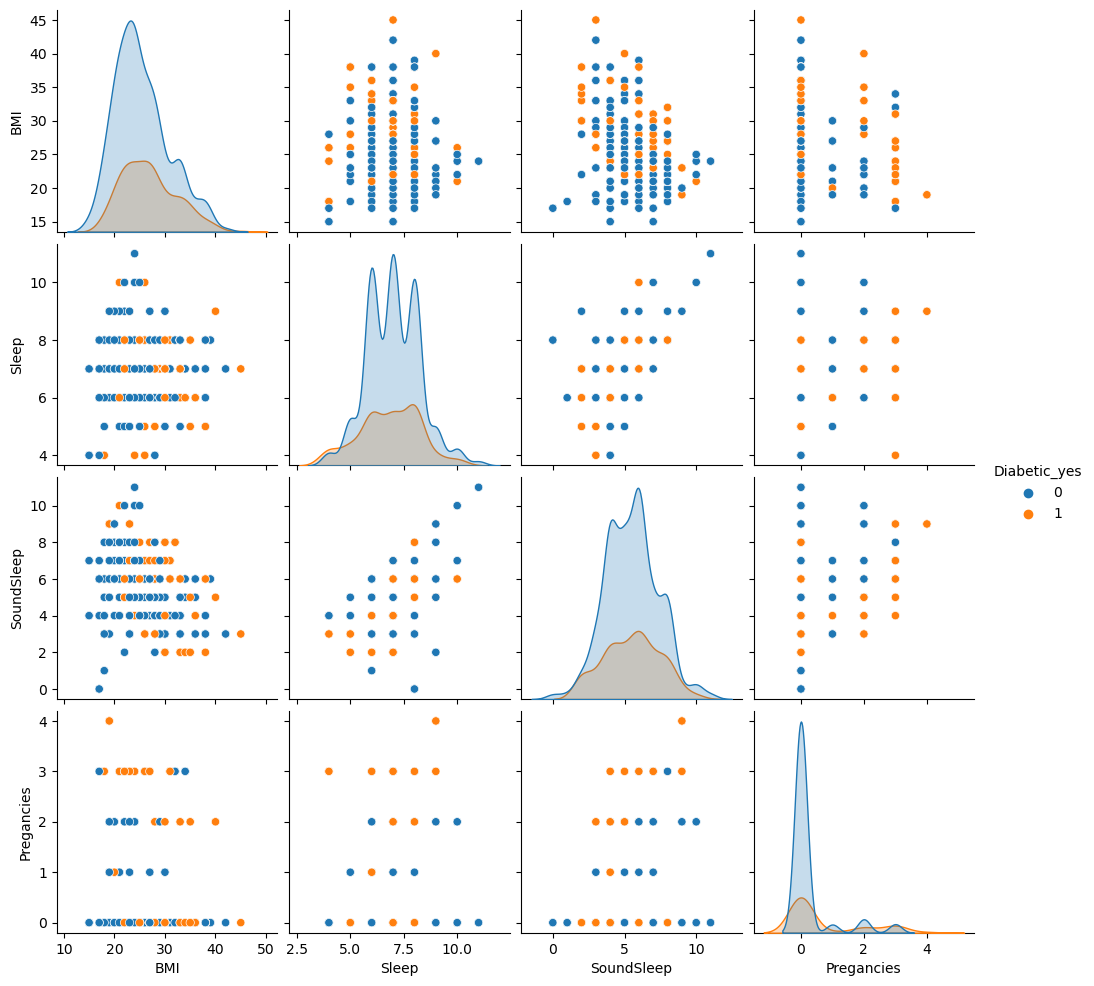

In [52]:
# pair plot
sns.pairplot(diabdata_encoded, hue = "Diabetic_yes")

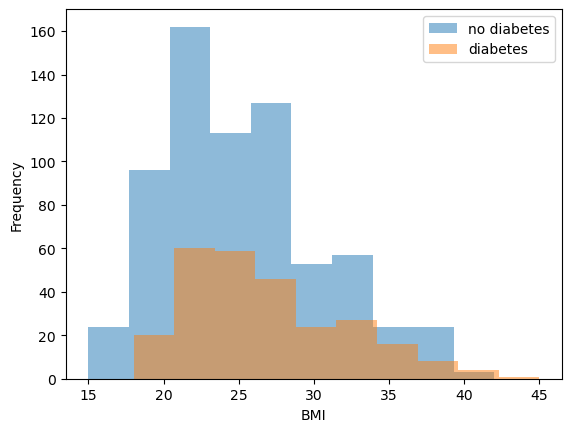

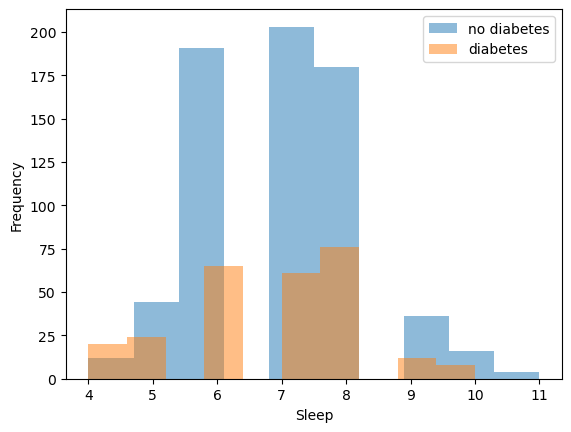

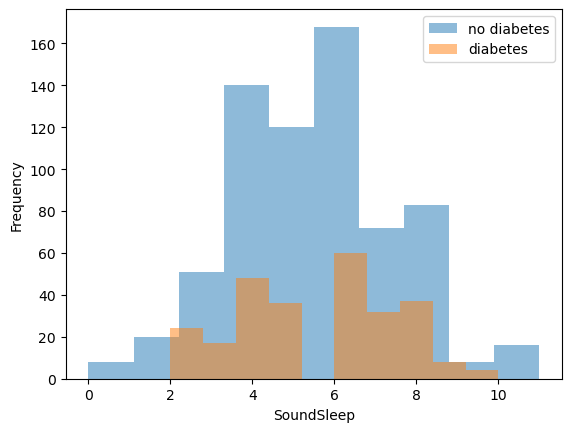

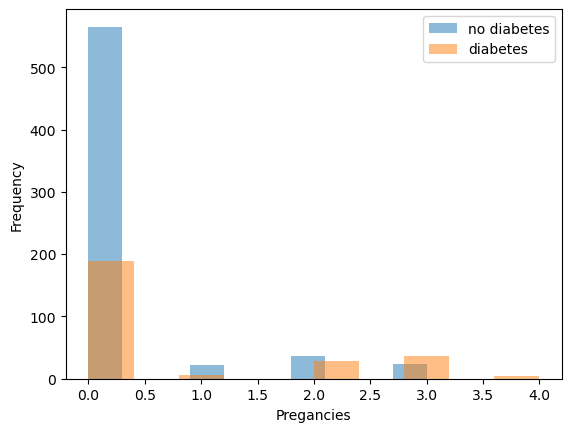

In [53]:
for col in ['BMI', 'Sleep', 'SoundSleep', 'Pregancies']:
    plt.hist(diabdata_encoded[diabdata_encoded['Diabetic_yes'] ==  0][col], 10, alpha = 0.5, label = 'no diabetes')
    plt.hist(diabdata_encoded[diabdata_encoded['Diabetic_yes'] == 1][col], 10, alpha = 0.5, label = 'diabetes')
    plt.legend(loc = 'upper right')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

<Axes: xlabel='Diabetic_yes', ylabel='count'>

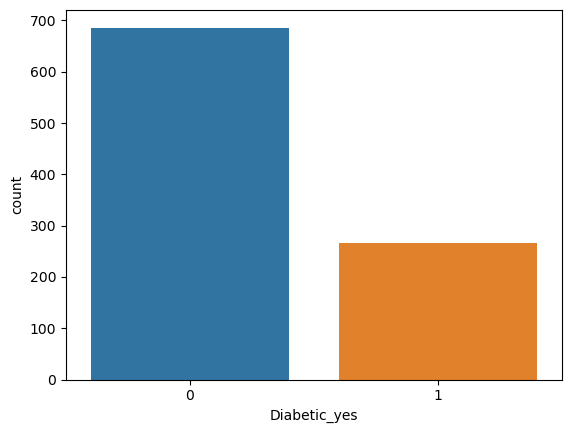

In [56]:
# Counting diabetes outcome
sns.countplot(x = 'Diabetic_yes', data = diabdata_encoded)


C:\Users\Junhee\AppData\Local\Temp\ipykernel_21588\1061305226.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(diabdata_encoded.corr(), annot = True)


<Axes: >

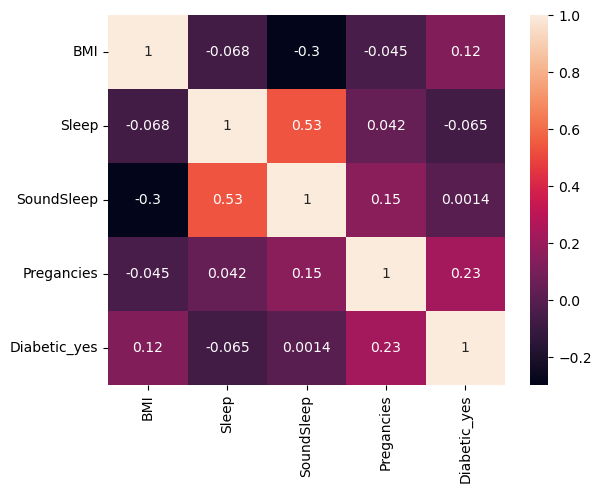

In [57]:
sns.heatmap(diabdata_encoded.corr(), annot = True)

In [59]:
# Dropping low correlation attributes
final_diabdata = diabdata_encoded.drop(['Sleep', 'SoundSleep'], axis = 1)
final_diabdata

,Age,Gender,Family_Diabetes,highBP,PhysicallyActive,BMI,Smoking,Alcohol,RegularMedicine,JunkFood,Stress,BPLevel,Pregancies,Pdiabetes,UriationFreq,Diabetic_yes
0,50-59,Male,no,yes,one hr or more,39.0,no,no,no,occasionally,sometimes,high,0.0,0,not much,0
1,50-59,Male,no,yes,less than half an hr,28.0,no,no,yes,very often,sometimes,normal,0.0,0,not much,0
2,40-49,Male,no,no,one hr or more,24.0,no,no,no,occasionally,sometimes,normal,0.0,0,not much,0
3,50-59,Male,no,no,one hr or more,23.0,no,no,no,occasionally,sometimes,normal,0.0,0,not much,0
4,40-49,Male,no,no,less than half an hr,27.0,no,no,no,occasionally,sometimes,normal,0.0,0,not much,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,less than 40,Male,yes,no,more than half an hr,25.0,no,no,no,often,sometimes,normal,0.0,0,not much,1
948,60 or older,Male,yes,yes,more than half an hr,27.0,no,no,yes,occasionally,sometimes,high,0.0,0,quite often,1
949,60 or older,Male,no,yes,none,23.0,no,no,yes,occasionally,sometimes,high,0.0,0,not much,0
950,60 or older,Male,no,yes,less than half an hr,27.0,no,yes,yes,occasionally,very often,high,0.0,0,not much,0


In [7]:
#compute a simple cross tabulation of two (or more) factors
cross_tab_junk_stress = pd.crosstab(diabdata['JunkFood'], diabdata['Stress']) 
#want only first two values of tuple returned from chi2_contingency
#This function computes the chi-square statistic and p-value for the 
#hypothesis test of independence of the observed frequencies in the contingency table
chi2, p_value, df, expvals = chi2_contingency(cross_tab_junk_stress)
print("Chi-square:", chi2)
print("P-value:", p_value)
#We can assume from the low p value that junk food and stress are associated
#However, we will use both since their nature is different

Chi-square: 94.09466967499688
P-value: 2.4470337530291514e-16


In [8]:
cross_tab_junk_blood = pd.crosstab(diabdata['JunkFood'], diabdata['BPLevel']) 
chi2, p_value, df, expvals = chi2_contingency(cross_tab_junk_blood)
print("Chi-square:", chi2)
print("P-value:", p_value)
#Here, we see that junk food as blood pressure are not that highly correlated because the p-val > 0.05
#The chi-square value is also relatively low, demonstraing the above

Chi-square: 24.951722830335264
P-value: 0.05059555690352423


In [9]:
cross_tab_high_blood = pd.crosstab(diabdata['highBP'], diabdata['BPLevel']) 
chi2, p_value, df, expvals = chi2_contingency(cross_tab_high_blood)
print("Chi-square:", chi2)
print("P-value:", p_value)
#As expetced, the variables highBP and BPlevels are highly correlated because they relate both to blood pressure
#Because of the extremely high chi-square and low p-val we are likely to omit one of the two

Chi-square: 482.23875003776743
P-value: 5.439974203257661e-102


In [10]:
diabdata.dropna(subset = ['BMI', 'Sleep', 'SoundSleep'], inplace=True) #drops nan values from quantitative variables for now
diab_quant = diabdata[['BMI', 'Sleep', 'SoundSleep']] #the quantiative variables we want
target = diabdata['Diabetic'] #the label we want to predict
lab_encoder = LabelEncoder() #encode target labels with value between 0 and n_classes-1
target = lab_encoder.fit_transform(target) #transform target lab encoded
#split into 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(diab_quant, target, test_size = 0.2, random_state = 12)
#knn instant with 5 neighbors
knn_classifier = KNeighborsClassifier(n_neighbors = 5)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test) #show original yes/no's instead of 1/2's
predicted = lab_encoder.inverse_transform(y_pred)
true = lab_encoder.inverse_transform(y_test)
for pred, true in zip(predicted, true):
    print(f"Predicted: {pred}\tTrue: {true}")

Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: yes
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: no	True: no
Predicted: no	True: no
Predicted: yes	True: yes
Predicted: no	True: no
Predicted: no	True: yes
Predicted: no	True: no
Predicted: n

In [11]:
true_labs = lab_encoder.inverse_transform(y_test) #there was an issue if I didn't inverse transform
predicted = predicted
conf_mat = confusion_matrix(true_labs, predicted)
conf_mat

array([[121,  18],
       [ 23,  28]], dtype=int64)

In [12]:
acc_sco = accuracy_score(true_labs, predicted)
acc_sco

0.7842105263157895

In [13]:
XMLP = diabdata.drop('Diabetic', axis=1)
yMLP = diabdata['Diabetic']
cat_MLP = ['Gender', 'Family_Diabetes', 'PhysicallyActive', 'Smoking', 'Alcohol', 'JunkFood', 'BPLevel']
num_MLP = ['BMI','Sleep','SoundSleep']
#encode categorical variables and scale quantitative
preprocessor_MLP = ColumnTransformer(transformers = [
    ('cat', OneHotEncoder(), cat_MLP),
    ('num', StandardScaler(), num_MLP)
])
XMLP_preproc = preprocessor_MLP.fit_transform(XMLP) #apply preprocessing

#train-test 80-20
X_trainMLP, X_testMLP, y_trainMLP, y_testMLP = train_test_split(XMLP_preproc, yMLP, test_size=0.2, random_state=12)
#using standard MLPClassifier activation and solver, as well as hidden layer sizes of 100 neurons for 2 layers
mlp = MLPClassifier(hidden_layer_sizes = (100,100), activation = 'relu', 
                    solver = 'adam', random_state = 12, max_iter=300)

mlp.fit(X_trainMLP, y_trainMLP)
y_predMLP = mlp.predict(X_testMLP)
accMLP = np.mean(y_predMLP == y_testMLP)
accMLP

0.9631578947368421

In [32]:
from sklearn.model_selection import GridSearchCV

activations = ['relu', 'logistic']
solvers = ['sgd', 'adam']
max_iterations = [1000,1100,1200]
hidden_layer_siz = [(5, 7), (7, 13), (13, 10), (100,100)]
learning_rates = 0.01 * np.arange(1, 3)

param_grid = dict(learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations, activation = activations, solver = solvers)
# set model
mlp = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = 0.3, batch_size = 100, hidden_layer_sizes = (12, 3), max_iter = 500)

# For Grid Search
grid = GridSearchCV(estimator = mlp, param_grid = param_grid)

grid.fit(X_trainMLP,y_trainMLP)

print("Optimal Hyper-parameters : ", grid.best_params_)
print("Optimal Accuracy : ", grid.best_score_)

c:\Users\jpsal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Optimal Hyper-parameters :  {'activation': 'logistic', 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.02, 'max_iter': 1000, 'solver': 'adam'}
Optimal Accuracy :  0.922168002788428
